# Sanitizing Data

Often data is messy. In our case we have two problems with the data.

 - values are missing
 - not in a format easy to do machine learning on.
 
Machine Learning algorithms and in general all statistics algorithms like arrays.

In [116]:
import json
from collections import defaultdict
import re

import pandas as pd
import numpy as np
import requests

def convert_dict_to_pandas_frame(data, dict_frames):
    data_columns = defaultdict(list)
    for d in data.values():
        for key in dict_frames:
            subkey = d
            subkeys = dict_frames[key].split('.')
            for k in subkeys:
                if re.match(r'\d+', k) and subkey is not None:
                    index = int(k)
                    if index >= len(subkey):
                        subkey = None
                    else:
                        subkey = subkey[index]
                else:
                    if subkey is not None:
                        subkey = subkey.get(k)
            data_columns[key].append(subkey)
    df = pd.DataFrame.from_dict(data_columns)
    return df.set_index('material_id')

In [117]:
## data will not be available locally so we need to download it
# data = json.load(open('../data/mpdata.json'))
data = requests.get('https://gitlab.com/costrouc/mse-machinelearning-notebooks/raw/master/data/mpdata.json').json()
print('Number of materials', len(data))

Number of materials 6928


If we look at one of the materials we can see that the data is not in the best format.

In [6]:
first_key = next(iter(data))
data[first_key]

{'energy': -4.0645998,
 'energy_per_atom': -4.0645998,
 'volume': 11.852765009390795,
 'formation_energy_per_atom': 0.03469247000000042,
 'nsites': 1,
 'unit_cell_formula': {'Cu': 1.0},
 'pretty_formula': 'Cu',
 'is_hubbard': False,
 'elements': ['Cu'],
 'nelements': 1,
 'e_above_hull': 0.03469247000000042,
 'hubbards': {},
 'is_compatible': True,
 'spacegroup': {'source': 'spglib',
  'symbol': 'Im-3m',
  'number': 229,
  'point_group': 'm-3m',
  'crystal_system': 'cubic',
  'hall': '-I 4 2 3'},
 'task_ids': ['mp-998890',
  'mp-998895',
  'mp-998898',
  'mp-998906',
  'mp-1056211',
  'mp-1056219',
  'mp-1056226',
  'mp-1056233'],
 'band_gap': 0.0,
 'density': 8.902615866613178,
 'icsd_id': None,
 'icsd_ids': [183263],
 'cif': "# generated using pymatgen\ndata_Cu\n_symmetry_space_group_name_H-M   'P 1'\n_cell_length_a   2.48779079\n_cell_length_b   2.48779079\n_cell_length_c   2.48779079\n_cell_angle_alpha   109.47122063\n_cell_angle_beta   109.47122063\n_cell_angle_gamma   109.47122063

Always aim to convert your data to a tabular form first

In [118]:
key_map = {
    'material_id': 'material_id',
    'energy': 'energy',
    'volume': 'volume',
    'nsites': 'nsites',
    'energy_per_atom': 'energy_per_atom',
    'pretty_formula': 'pretty_formula',
    'spacegroup': 'spacegroup.number',
    'band_gap': 'band_gap',
    'density': 'density',
    'total_magnetization': 'total_magnetization',
    # Elacticity
    'poisson_ratio': 'elasticity.poisson_ratio',
    'bulk_modulus_voigt': 'elasticity.K_Voigt',
    'bulk_modulus_reuss': 'elasticity.K_Reuss',
    'bulk_modulus_vrh': 'elasticity.K_VRH',
    'shear_modulus_voigt': 'elasticity.G_Voigt',
    'shear_modulus_vrh': 'elasticity.G_VRH'
}

df = convert_dict_to_pandas_frame(data, key_map)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6928 entries, mp-998890 to mp-30883
Data columns (total 15 columns):
energy                 6928 non-null float64
volume                 6928 non-null float64
nsites                 6928 non-null int64
energy_per_atom        6928 non-null float64
pretty_formula         6928 non-null object
spacegroup             6928 non-null int64
band_gap               6928 non-null float64
density                6928 non-null float64
total_magnetization    6928 non-null float64
poisson_ratio          896 non-null float64
bulk_modulus_voigt     896 non-null float64
bulk_modulus_reuss     896 non-null float64
bulk_modulus_vrh       896 non-null float64
shear_modulus_voigt    896 non-null float64
shear_modulus_vrh      896 non-null float64
dtypes: float64(12), int64(2), object(1)
memory usage: 866.0+ KB


In [120]:
df.sample(5)

,energy,volume,nsites,energy_per_atom,pretty_formula,spacegroup,band_gap,density,total_magnetization,poisson_ratio,bulk_modulus_voigt,bulk_modulus_reuss,bulk_modulus_vrh,shear_modulus_voigt,shear_modulus_vrh
material_id,,,,,,,,,,,,,,,
mvc-15868,-102.229807,182.562400,20,-5.111490,ZnCoO3,62,0.0000,6.270250,4.401870,NaN,NaN,NaN,NaN,NaN,NaN
mp-714908,-278.665566,451.645416,42,-6.634894,Fe10O11,2,0.5045,5.400573,2.000009,NaN,NaN,NaN,NaN,NaN,NaN
mp-2327,-58.231276,518.171632,34,-1.712685,TiZn16,63,0.0000,7.014325,0.000033,0.341793,79.294827,78.599764,78.947295,29.014697,27.925264
mvc-12563,-183.252030,324.836376,28,-6.544715,Mn2ZnO4,59,0.2972,4.892780,32.000000,NaN,NaN,NaN,NaN,NaN,NaN
mp-1038987,-19.747382,310.753063,12,-1.645615,CaMg5,38,0.0000,1.727083,-0.000737,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
# write the data to a csv file
df.to_csv('../data/mpdata.csv')

# Lets Explore the Data

Exploring the data is important.

In [88]:
# how many materials are we looking at?
len(df)

6928

In [87]:
# look at most common spacegroups
df['spacegroup'].value_counts()[:25]

1      680
14     584
2      452
12     314
62     291
8      251
15     208
63     205
166    160
225    158
221    155
194    146
123    117
227    110
61     102
74      99
5       96
139     88
19      86
4       83
160     81
33      72
6       72
186     71
11      69
Name: spacegroup, dtype: int64

how many are metals? 2270 / 6928
material with highest band gap 17.8914 He


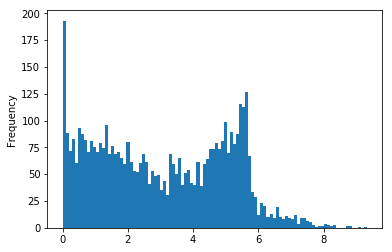

In [115]:
# band gaps
print('how many are metals?', len(df[df['band_gap'] == 0.0]), '/', len(df))
print('material with highest band gap', df['band_gap'].max(), df.loc[df['band_gap'].idxmax()]['pretty_formula'])

condition = (df['band_gap'] > 0.0) & (df['band_gap'] < 10)
df[condition]['band_gap'].plot.hist(bins=100)

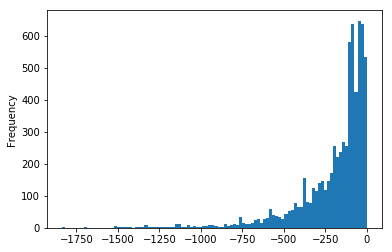

In [100]:
# cohesive energies
df['energy'].plot.hist(bins=100)

In [79]:
conditions = (df['shear_modulus_vrh'] > 0) & (df['shear_modulus_vrh'] < 500) & \
             (df['bulk_modulus_vrh'] > 0) & (df['bulk_modulus_vrh'] < 500) & \
             (df['poisson_ratio'] > 0) & (df['poisson_ratio'] < 0.5)

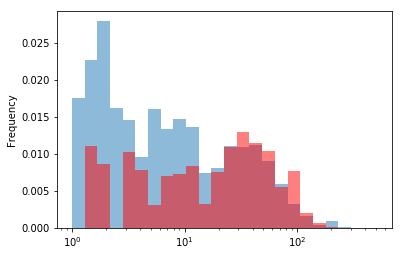

In [142]:
# shear modulus vrh of metals vs nonmetals

is_metal = df['band_gap'] == 0.0
is_not_metal = df['band_gap'] > 0.0
bins = 10**np.linspace(0, 2.7, 25) # 10^2.7 ~ 500
ax = df[conditions & is_not_metal]['shear_modulus_vrh'].plot.hist(bins=bins, alpha=0.5, density=True)
ax = df[conditions & is_metal]['shear_modulus_vrh'].plot.hist(ax=ax, bins=bins, color='red', alpha=0.5, density=True)
ax.set_xscale('log')

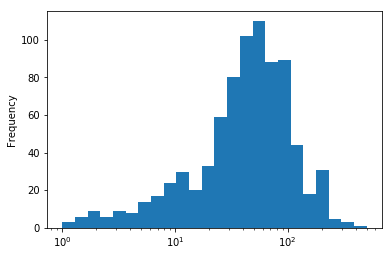

In [82]:
bins = 10**np.linspace(0, 2.7, 25) # 10^2.7 ~ 500
ax = df[conditions]['shear_modulus_vrh'].plot.hist(bins=bins)
ax.set_xscale('log')

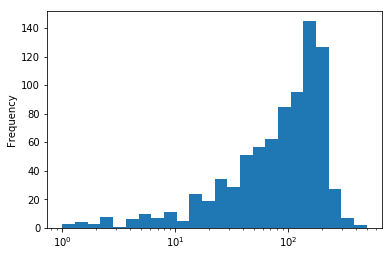

In [83]:
bins = 10**np.linspace(0, 2.7, 25)
ax = df[conditions]['bulk_modulus_vrh'].plot.hist(bins=bins)
ax.set_xscale('log')

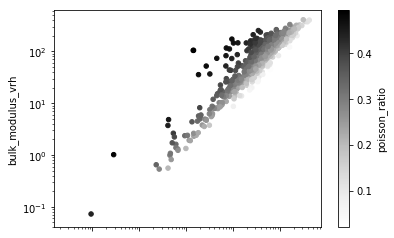

In [84]:
ax = df[conditions].plot(kind='scatter', x='shear_modulus_vrh', y='bulk_modulus_vrh', c='poisson_ratio')
ax.set_xscale('log')
ax.set_yscale('log')

Compare with publication [from materials project](https://www.nature.com/articles/sdata20159).

![Elastic Constant Image](../images/elasticity_calculations.png)

